In [46]:
from solver import Solver
from model import Net
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from experiment import get_data_loader
from lossfn import *

In [3]:
def get_train_range(dim):
    if dim == 2:
        train_range = range(1, 51, 1)
    elif dim == 3:
        train_range = range(10, 501, 10)
    elif dim == 5:
        train_range = range(50, 5001, 50)
    elif dim == 10:
        train_range = list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
    return train_range

In [4]:
def get_checkpoint_dir(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)
def get_checkpoint_dir2(dim, ntrain, lossfn, seed=1683):
    return 'checkpoints/checkpoints_lossfn2/checkpoints_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, ntrain, lossfn, seed)

In [5]:
loss_fns = ['error', 'det', 'norm', 'detnorm']

## Different loss functions

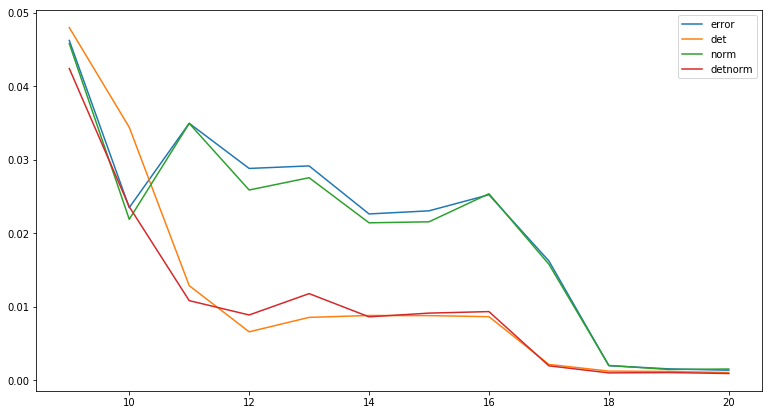

In [192]:
plt.figure(figsize=(13,7))
dim = 2
train_range = get_train_range(dim)
for lossfn in loss_fns:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 8, 20
    plt.plot(ntrains[l:r], test_loss[l:r], label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

## Different loss functions for dim=3

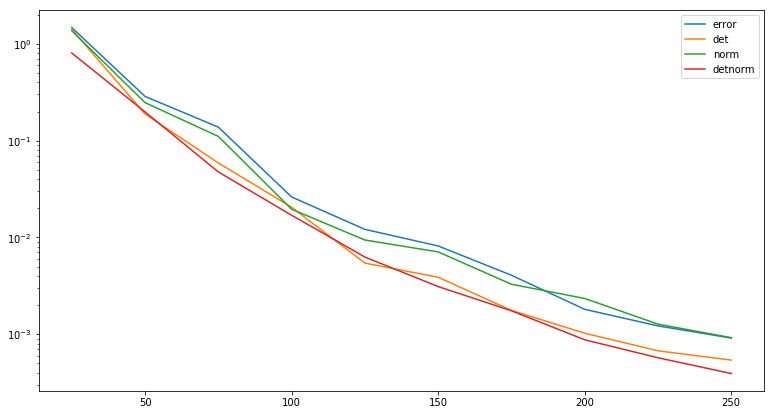

In [193]:
plt.figure(figsize=(13,7))
dim = 3
train_range = range(25, 251, 25)
for lossfn in loss_fns:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = get_checkpoint_dir2(dim, n_train, lossfn)+'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 0, 50
    plt.plot(ntrains[l:r], test_loss[l:r], label=lossfn)
plt.legend()
plt.yscale('log')
plt.show()

## Different loss functions for dim=5

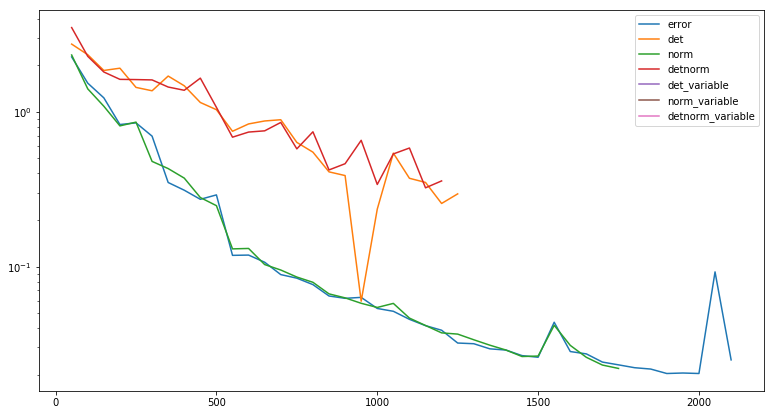

In [232]:
plt.figure(figsize=(13,7))
dim = 5
train_range = range(50, 5001, 50)
for lossfn in loss_fns:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 0, 50
    plt.plot(ntrains[l:r], test_loss[l:r], label=lossfn)
plt.legend()
plt.yscale('log')
plt.show()

n_train = 100, det_weight = 0.2


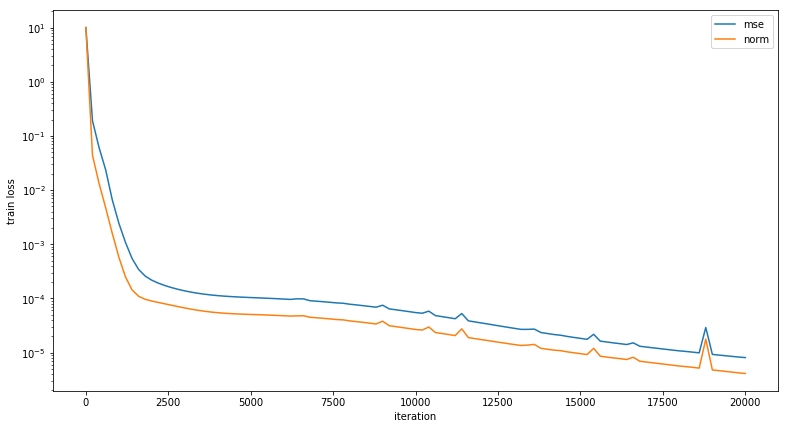

In [27]:
plt.figure(figsize=(13,7))
dim = 2
n_train = 100
det_weight = 0.2
lossfn='norm'
print("n_train = {}, det_weight = {}".format(n_train, det_weight))
path = 'checkpoints/checkpoints-normweight/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(0.5, 2, 10, 1683)
# Plot train loss
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
solver.load_checkpoint(path)
for key in solver.hist["individual_train_losses"]:
    plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key)
plt.legend()
plt.yscale('log')
plt.ylabel("train loss")
plt.xlabel("iteration")
plt.show()

## Different loss functions for dim=10

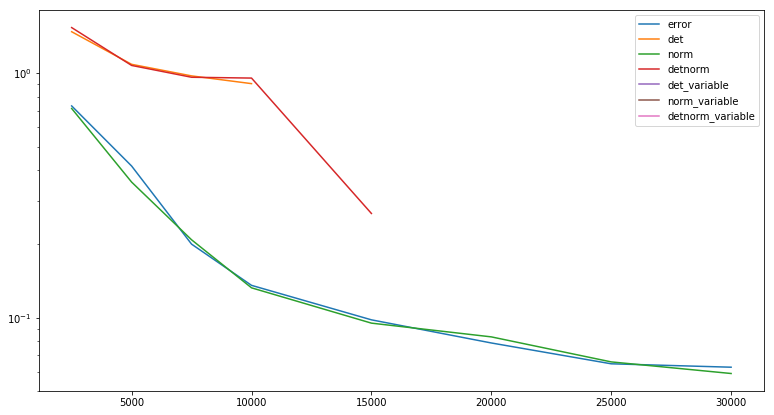

In [235]:
plt.figure(figsize=(13,7))
dim = 10
train_range =  list(range(2500, 10000, 2500)) + list(range(10000, 30000, 5000)) + list(range(30000, 500001, 10000))
for lossfn in loss_fns:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 0, 50
    plt.plot(ntrains[l:r], test_loss[l:r], label=lossfn)
plt.legend()
plt.yscale('log')
plt.show()

## Determinant for different angles

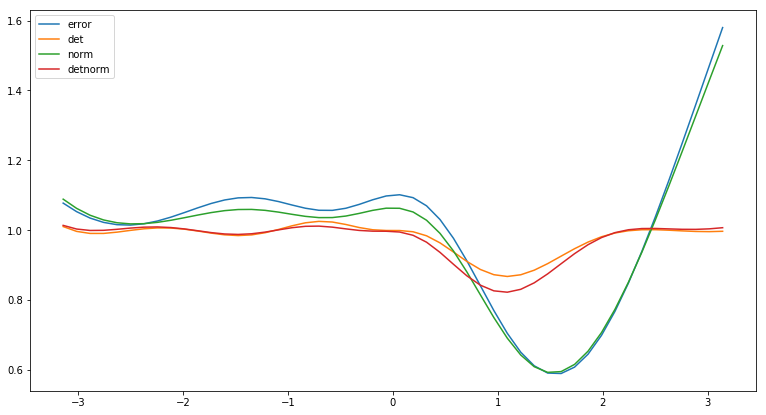

In [13]:
plt.figure(figsize=(13,7))
dim = 2
n_train = 10
for lossfn in loss_fns:
    dets = []
    model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
    solver = Solver(model)
    filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
    if os.path.exists(filepath):
        solver.load_checkpoint(filepath)
        alphas = np.linspace(-math.pi, math.pi)
        matrices = solver.model(torch.FloatTensor([[a] for a in alphas]))
        dets = [torch.det(mat) for mat in matrices]
        plt.plot(alphas, dets, label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

### Determinant for dim = 5

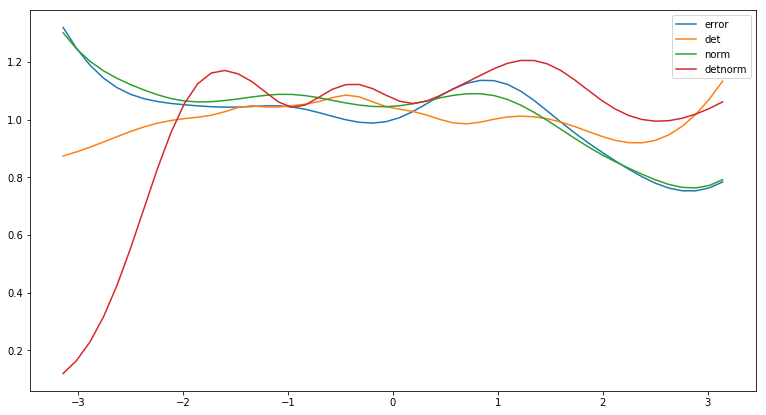

In [12]:
plt.figure(figsize=(13,7))
dim = 5
n_train = 1000
for lossfn in loss_fns:
    dets = []
    model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
    solver = Solver(model)
    filepath = get_checkpoint_dir(dim, n_train, lossfn)+'final.pkl'
    if os.path.exists(filepath):
        solver.load_checkpoint(filepath)
        alphas = np.linspace(-math.pi, math.pi)
        matrices = solver.model(torch.FloatTensor([[a, 0, 0, 0] for a in alphas]))
        dets = [torch.det(mat) for mat in matrices]
        plt.plot(alphas, dets, label=lossfn)
plt.legend()
# plt.yscale('log')
plt.show()

## Different det_weights

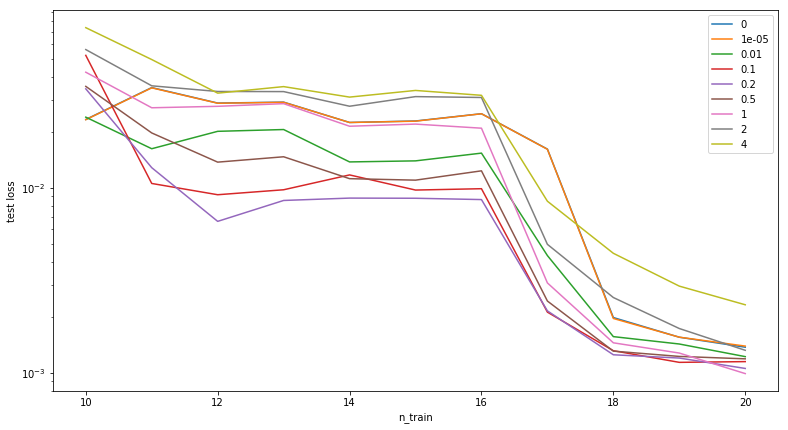

In [204]:
plt.figure(figsize=(13,7))
dim = 2
train_range = range(10, 21, 1)
for det_weight in [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]:# [0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10, 100]:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = 'checkpoints/checkpoints-detweight2/checkpoints_detweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(det_weight, dim, n_train, 1683)
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    l, r = 0, 30
    plt.plot(ntrains, test_loss, label=det_weight)
plt.legend()
plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()

## Train loss for specific det_weight

n_train = 15, det_weight = 0.2


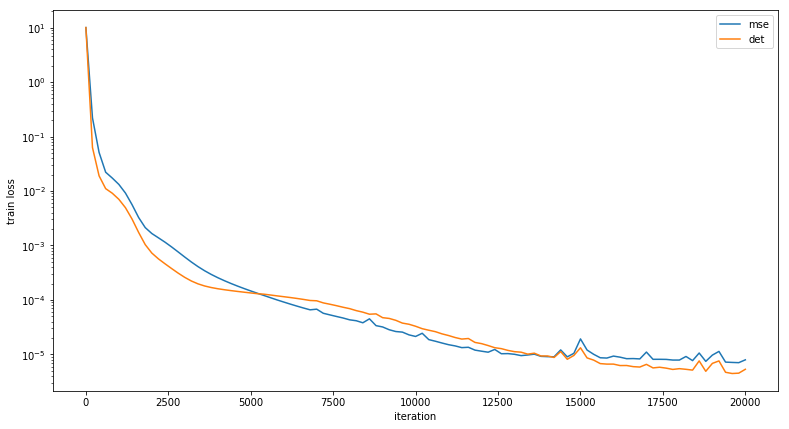

In [197]:
plt.figure(figsize=(13,7))
dim = 2
n_train = 15
det_weight = 0.2
print("n_train = {}, det_weight = {}".format(n_train, det_weight))
path = 'checkpoints/checkpoints-detweight/checkpoints_detweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(det_weight, dim, n_train, 1683)
# Plot train loss
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
solver.load_checkpoint(path)
for key in solver.hist["individual_train_losses"]:
    plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key)
plt.legend()
plt.yscale('log')
plt.ylabel("train loss")
plt.xlabel("iteration")
plt.show()

## Different weight_decays

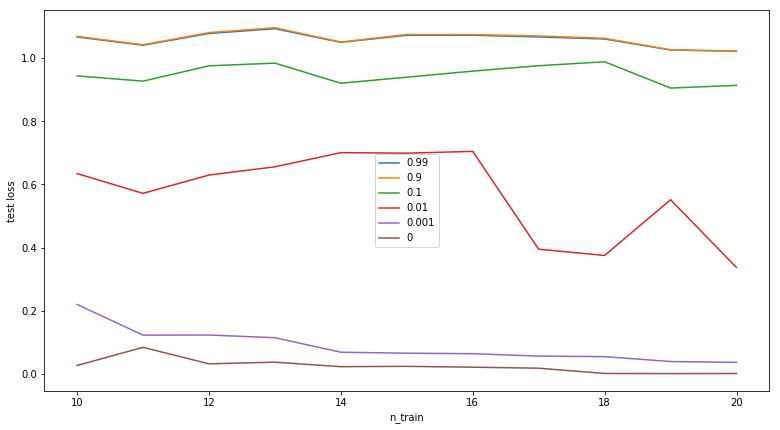

In [198]:
plt.figure(figsize=(13,7))
dim = 2
train_range = range(10, 21, 1)
train_seed = 1683
for weight_decay in [0.99, 0.9, 0.1, 0.01, 0.001, 0]:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'checkpoints_weight_decay_mse/'
        checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_weightdecay-{}_seed-{}'.format(dim, n_train, weight_decay,
                                                                                      train_seed)
        filepath = checkpoint_dir + 'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    plt.plot(ntrains, test_loss, label=weight_decay)
plt.legend()
# plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()

## Statistical final test loss

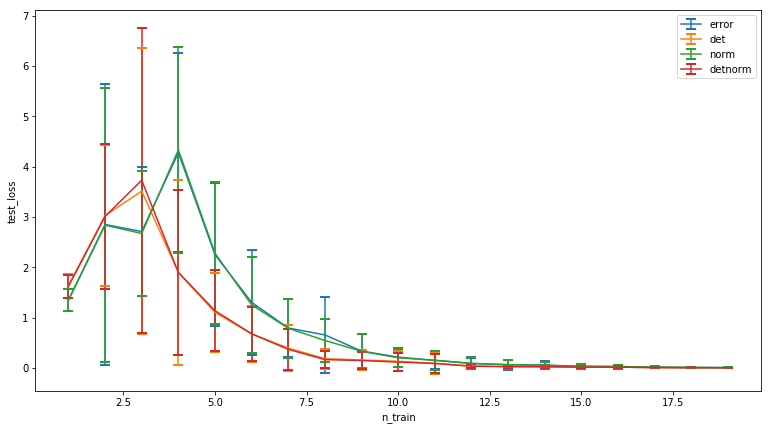

In [20]:
plt.figure(figsize=(13,7))
dim = 2
n_runs = 20
train_range = range(1, 20, 1)
for i, lossfnstr in enumerate(['error', 'det', 'norm', 'detnorm']):# ['error', 'det', 'norm', 'detnorm']:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        test_loss_n_train = []
        ntrains.append(n_train)
        for train_seed in range(1683, 1683 + n_runs, 1):
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            checkpoint_dir = 'checkpoints/'
            checkpoint_dir += 'checkpoints_statistical/'
            checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(
                dim, n_train, lossfnstr, train_seed)
            filepath = checkpoint_dir+'final.pkl'
            if os.path.exists(filepath):
                solver.load_checkpoint(filepath)
                test_loss_n_train.append(solver.hist["test_loss"][-1])
            else:
                print(filepath)
        test_loss.append(test_loss_n_train)
    test_loss = np.array(test_loss)
    if len(test_loss):
        plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=lossfnstr)
plt.legend()
plt.xlabel("n_train")
plt.ylabel("test_loss")
# plt.yscale('log')
plt.show()

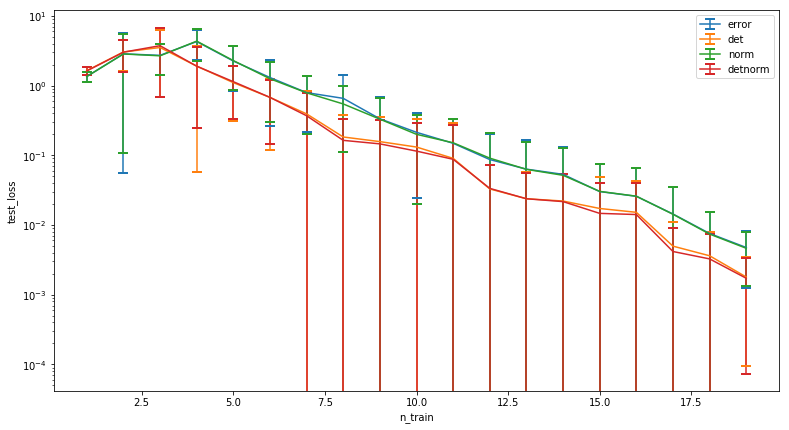

In [21]:
plt.figure(figsize=(13,7))
dim = 2
n_runs = 20
train_range = range(1, 20, 1)
for i, lossfnstr in enumerate(['error', 'det', 'norm', 'detnorm']):# ['error', 'det', 'norm', 'detnorm']:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        test_loss_n_train = []
        ntrains.append(n_train)
        for train_seed in range(1683, 1683 + n_runs, 1):
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            checkpoint_dir = 'checkpoints/'
            checkpoint_dir += 'checkpoints_statistical/'
            checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(
                dim, n_train, lossfnstr, train_seed)
            filepath = checkpoint_dir+'final.pkl'
            if os.path.exists(filepath):
                solver.load_checkpoint(filepath)
                test_loss_n_train.append(solver.hist["test_loss"][-1])
            else:
                print(filepath)
        test_loss.append(test_loss_n_train)
    test_loss = np.array(test_loss)
    if len(test_loss):
        plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=lossfnstr)
plt.legend()
plt.xlabel("n_train")
plt.ylabel("test_loss")
plt.yscale('log')
plt.show()

## Different norm loss weights

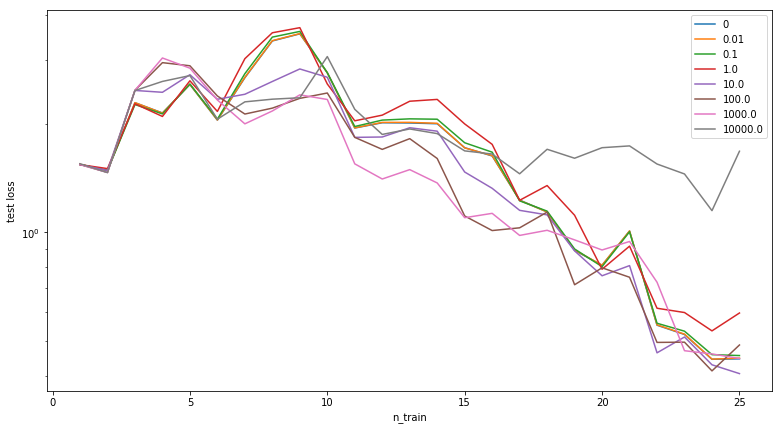

In [62]:
plt.figure(figsize=(13,7))
dim = 3
train_range = range(1, 26, 1)
norm_weights = [0, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
for norm_weight in norm_weights:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        filepath = 'checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            norm_weight, dim, n_train, 1683)
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    plt.plot(ntrains, test_loss, label=norm_weight)
plt.legend()
plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()

n_train = 25, norm_weight = 10000.0


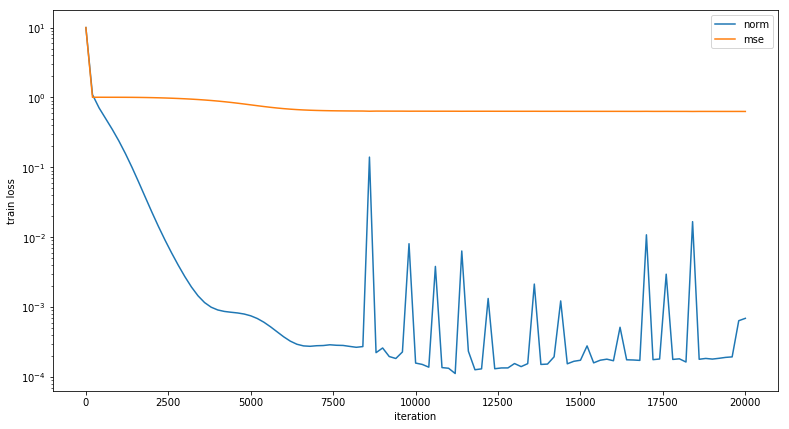

In [64]:
plt.figure(figsize=(13,7))
dim = 2
n_train = 25
norm_weight = 1e4
train_seed = 1683
print("n_train = {}, norm_weight = {}".format(n_train, norm_weight))
path = 'checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            norm_weight, dim, n_train, train_seed)
# Plot train loss
model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
solver = Solver(model)
solver.load_checkpoint(path)
for key in solver.hist["individual_train_losses"]:
    plt.plot(solver.hist["iterations"], solver.hist["individual_train_losses"][key], label=key)
plt.legend()
plt.yscale('log')
plt.ylabel("train loss")
plt.xlabel("iteration")
plt.show()

In [50]:
train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=True, batch_size=512)
for (points, angles, points_rotated) in train_loader:
    output_matrix = solver.model(angles)
    prediction = torch.bmm(output_matrix, points.view((points.shape[0], points.shape[1], 1)))
    prediction = prediction.view((points.shape[0], points.shape[1]))
    print(prediction[:2])
    print(points_rotated[:2])
    print(get_norm_loss()(prediction, points_rotated, output_matrix))

tensor([[ 0.2156,  0.9766],
        [-0.9252, -0.3803]], grad_fn=<SliceBackward>)
tensor([[ 0.9540, -0.3000],
        [-0.8423, -0.5390]])
tensor(1.1153e-07, grad_fn=<DivBackward0>)


## Statistical norm loss weights

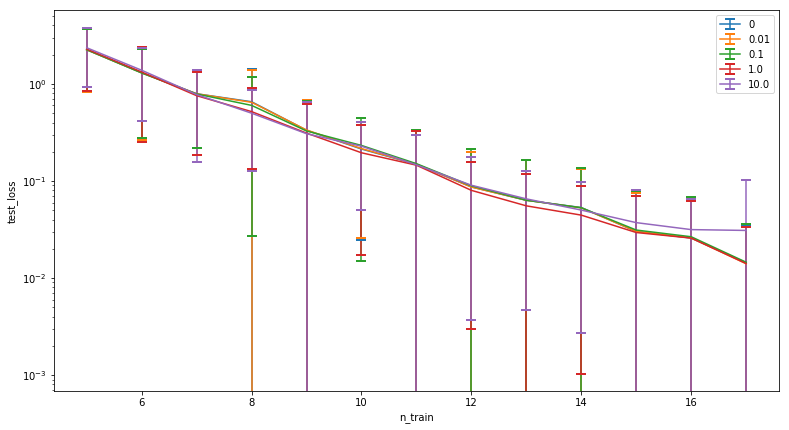

In [70]:
plt.figure(figsize=(13,7))
dim = 2
n_runs = 20
train_range = range(5, 18, 1)
norm_weights = [0, 1e-2, 1e-1, 1e0, 1e1]
for i, norm_weight in enumerate(norm_weights):
    test_loss = []
    ntrains = []
    for n_train in train_range:
        test_loss_n_train = []
        ntrains.append(n_train)
        for train_seed in range(1683, 1683 + n_runs, 1):
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            filepath = 'checkpoints/checkpoints-normweight_new/checkpoints_normweight-{}_dim-{}_ntrain-{}_seed-{}/final.pkl'.format(
                            norm_weight, dim, n_train, train_seed)
            if os.path.exists(filepath):
                solver.load_checkpoint(filepath)
                test_loss_n_train.append(solver.hist["test_loss"][-1])
            else:
                print(filepath)
        test_loss.append(test_loss_n_train)
    test_loss = np.array(test_loss)
    if len(test_loss):
        plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=norm_weight)
plt.legend()
plt.xlabel("n_train")
plt.ylabel("test_loss")
plt.yscale('log')
plt.show()

## Additional unsupervised data

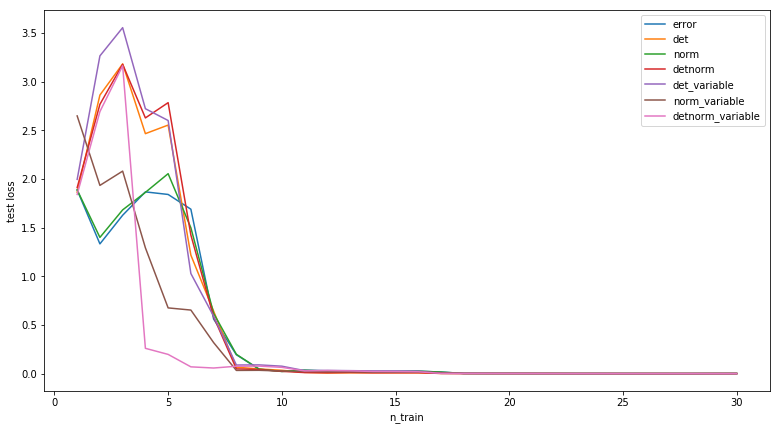

In [224]:
plt.figure(figsize=(13,7))
loss_fns = ['error', 'det', 'norm', 'detnorm', 'det_variable', 'norm_variable', 'detnorm_variable']
dim = 2
train_range = range(1, 31, 1)
for lossfnstr in ['error', 'det', 'norm', 'detnorm', 'det_variable', 'norm_variable', 'detnorm_variable']:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'checkpoints_semisupervised/'
        checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, n_train, lossfnstr,
                                                                                  1683)
        filepath = checkpoint_dir + 'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    plt.plot(ntrains, test_loss, label=lossfnstr)
plt.legend()
# plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()

## Unsupervised data log scale

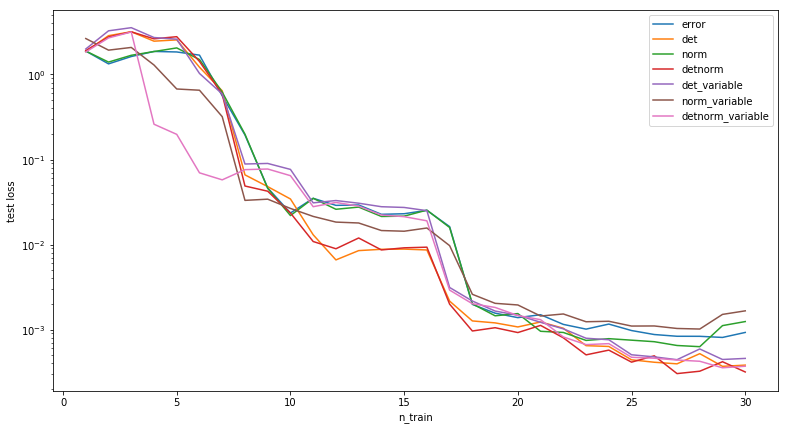

In [206]:
plt.figure(figsize=(13,7))
loss_fns = ['error', 'det', 'norm', 'detnorm', 'det_variable', 'norm_variable', 'detnorm_variable']
dim = 2
train_range = range(1, 31, 1)
for lossfnstr in ['error', 'det', 'norm', 'detnorm', 'det_variable', 'norm_variable', 'detnorm_variable']:
    test_loss = []
    ntrains = []
    for n_train in train_range:
        model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
        solver = Solver(model)
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'checkpoints_semisupervised/'
        checkpoint_dir += 'checkpoint_dim-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, n_train, lossfnstr,
                                                                                  1683)
        filepath = checkpoint_dir + 'final.pkl'
        if os.path.exists(filepath):
            ntrains.append(n_train)
            solver.load_checkpoint(filepath)
            test_loss.append(solver.hist["test_loss"][-1])
    plt.plot(ntrains, test_loss, label=lossfnstr)
plt.legend()
plt.yscale('log')
plt.ylabel("test loss")
plt.xlabel("n_train")
plt.show()